In [16]:
import pandas as pd
import utils
import plotly.express as px

color_discrete_map = {'ORF': 'rgb(0,114,178)',
                      'CRISPR': 'rgb(213,94,0)'}

TODO

In [17]:
matching_df = pd.DataFrame()
feature_to_group_by = "Metadata_broad_sample"
batch = "2020_11_04_CPJUMP1"

experiment_df = (
    pd.read_csv('output/experiment-metadata.tsv', sep='\t')
    .query('Batch==@batch')
    .query('Density=="100"')
    .query('Antibiotics=="absent"')
)

experiment_df.drop(experiment_df[(experiment_df.Perturbation == "compound") & (experiment_df.Cell_line == "Cas9")].index, inplace=True)

target1_metadata = (
    pd.read_csv('input/JUMP-Target-1_compound_metadata_additional_annotations.tsv', sep='\t', usecols=['broad_sample', 'target_list'])
    .rename(columns={'broad_sample':'Metadata_broad_sample', 'target_list':'Metadata_target_list'})
)

In [18]:
for cell in experiment_df.Cell_type.unique():
    cell_df = experiment_df.query('Cell_type==@cell')
    modality_1_perturbation = "compound"
    modality_1_experiments_df = cell_df.query('Perturbation==@modality_1_perturbation')
    for modality_1_timepoint in modality_1_experiments_df.Time.unique():
        modality_1_timepoint_df = modality_1_experiments_df.query('Time==@modality_1_timepoint')
        modality_1_df = pd.DataFrame()
        for plate in modality_1_timepoint_df.Assay_Plate_Barcode.unique():
            # Read all the plates
            data_df = (
                utils.load_data(batch, plate, "normalized_feature_select_negcon_batch.csv.gz")
                .assign(Metadata_modality=modality_1_perturbation)
            )
            modality_1_df = utils.concat_profiles(modality_1_df, data_df)

        # Remove DMSO and empty wells
        modality_1_df = utils.remove_negcon_empty_wells(modality_1_df)

        # Create consensus profiles
        modality_1_consensus_df = utils.consensus(modality_1_df, feature_to_group_by)

        # Adding additional gene annotation metadata
        modality_1_consensus_df = (
            modality_1_consensus_df.merge(target1_metadata, on='Metadata_broad_sample', how='left')
        )

        # Expand compound profiles and add new matching_target column
        modality_1_consensus_expanded_df = (
            modality_1_consensus_df.assign(Metadata_matching_target= lambda x: x.Metadata_target_list.str.split('|'))
            .explode('Metadata_matching_target')
            .reset_index(drop=True)
        )

        all_modality_2_experiments_df = cell_df.query('Perturbation!=@modality_1_perturbation')
        for modality_2_perturbation in all_modality_2_experiments_df.Perturbation.unique():
            modality_2_experiments_df = all_modality_2_experiments_df.query('Perturbation==@modality_2_perturbation')
            for modality_2_timepoint in modality_2_experiments_df.Time.unique():
                modality_2_timepoint_df = modality_2_experiments_df.query('Time==@modality_2_timepoint')

                modality_2_df = pd.DataFrame()
                for plate in modality_2_timepoint_df.Assay_Plate_Barcode.unique():
                    data_df = (
                        utils.load_data(batch, plate, "normalized_feature_select_negcon_batch.csv.gz")
                        .assign(Metadata_modality=modality_2_perturbation)
                        .assign(Metadata_matching_target=lambda x: x.Metadata_gene)
                    )
                    modality_2_df = utils.concat_profiles(modality_2_df, data_df)
                
                # Remove negcon and empty wells
                modality_2_df = utils.remove_negcon_empty_wells(modality_2_df)

                # Create consensus profiles (Replicates and sister guides are collapsed)
                modality_2_consensus_df = utils.consensus(modality_2_df, "Metadata_matching_target")

                # Calculate gene-compound matching mAP
                description = f'{modality_1_perturbation}_{cell}_{utils.time_point(modality_1_perturbation, modality_1_timepoint)}-{modality_2_perturbation}_{cell}_{utils.time_point(modality_2_perturbation, modality_2_timepoint)}'
                print(f'Computing {description} matching')
                precision = utils.PrecisionScores(modality_1_consensus_expanded_df, modality_2_consensus_df, "Metadata_matching_target", "matching", "Metadata_broad_sample")

                corr_unstacked = (
                    precision.corr
                    .unstack()
                    .reset_index()
                    .rename(columns={0: 'cosine_sim'})
                    .merge(precision.map2[["Metadata_sample_id", "Metadata_matching_target"]], left_on='level_0', right_on='Metadata_sample_id', how='left')
                    .drop(['Metadata_sample_id'], axis=1)
                    .merge(precision.map1[["Metadata_sample_id","Metadata_broad_sample"]], left_on='level_1', right_on='Metadata_sample_id', how='left')
                    .drop(['Metadata_sample_id'], axis=1)
                )

                truth_unstacked = (
                    precision.truth_matrix
                    .unstack()
                    .reset_index()
                    .rename(columns={0: 'pairs'})
                )

                corr_truth = (
                    corr_unstacked.merge(truth_unstacked, on=['level_0', 'level_1'], how='inner')
                    .assign(Modality1=f'{modality_1_perturbation}')
                    .assign(Genetic_Perturbation=f'{modality_2_perturbation}')
                    .assign(Cell=cell)
                    .query('pairs==True')
                    .assign(n_targets=1)
                )

                matching_df = utils.concat_profiles(matching_df, corr_truth)



Computing compound_U2OS_short-crispr_U2OS_long matching
Computing compound_U2OS_short-crispr_U2OS_short matching
Computing compound_U2OS_short-orf_U2OS_short matching
Computing compound_U2OS_short-orf_U2OS_long matching
Computing compound_U2OS_long-crispr_U2OS_long matching
Computing compound_U2OS_long-crispr_U2OS_short matching
Computing compound_U2OS_long-orf_U2OS_short matching
Computing compound_U2OS_long-orf_U2OS_long matching


In [19]:
matching_df = matching_df.replace({'compound':'Compound','crispr':'CRISPR','orf':'ORF'})

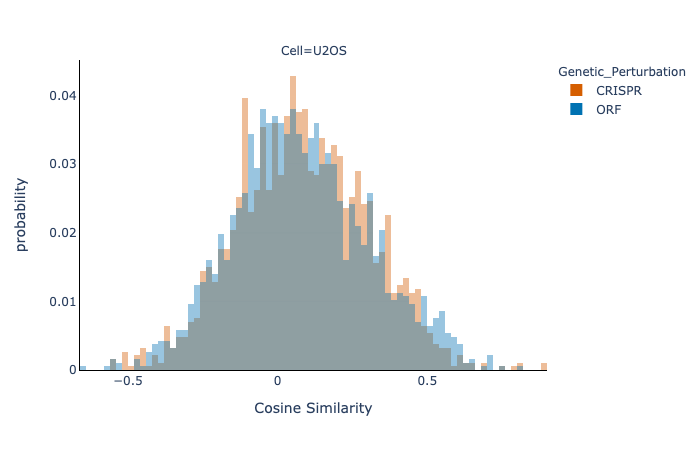

In [20]:
fig = px.histogram(
    matching_df,
    x = 'cosine_sim',
    color = 'Genetic_Perturbation',
    facet_col = 'Cell',
    opacity=0.4,
    histnorm='probability',
    barmode='overlay',
    color_discrete_map=color_discrete_map
    )
fig.update_layout(
    xaxis1=dict(title='Cosine Similarity', linecolor = "#000000"),
    xaxis2=dict(title='Cosine Similarity', linecolor = "#000000"),
    yaxis1=dict(linecolor = "#000000"),
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
)
fig.for_each_annotation(lambda a: a.update(text=a.text.replace("Modality1=", "")))
fig.show("png")
fig.write_image('figures/5.cosine_similarities.png', width=640, height=480, scale=2)

In [21]:
matching_df = matching_df.groupby(['Cell','Modality1','Genetic_Perturbation','Metadata_broad_sample']).agg(
    {'cosine_sim' : lambda x: x.mean(),
    'n_targets': lambda y: y.sum()}).reset_index()


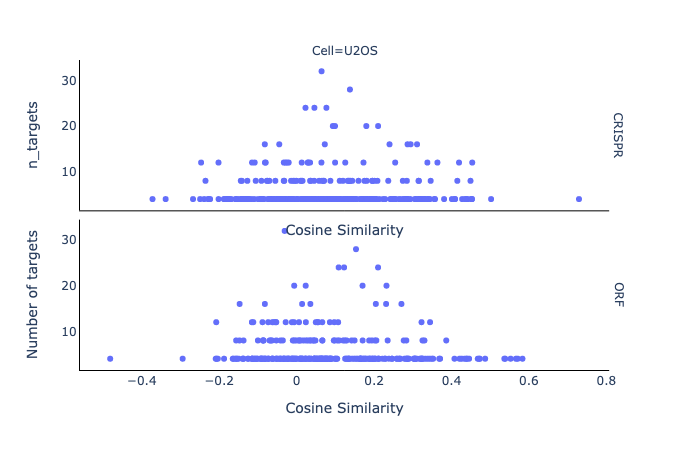

In [22]:
fig = px.scatter(
    matching_df,
    x='cosine_sim',
    y='n_targets',
    facet_col = 'Cell',
    facet_row = 'Genetic_Perturbation'
)
fig.update_layout(
    xaxis1=dict(title='Cosine Similarity', linecolor = "#000000"),
    xaxis2=dict(title='Cosine Similarity', linecolor = "#000000"),
    xaxis3=dict(linecolor = "#000000"),
    xaxis4=dict(linecolor = "#000000"),
    yaxis1=dict(title='Number of targets', linecolor = "#000000"),
    yaxis2=dict(linecolor = "#000000"),
    yaxis3=dict(title='Number of targets', linecolor = "#000000"),
    yaxis4=dict(linecolor = "#000000"),
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
)
fig.for_each_annotation(lambda a: a.update(text=a.text.replace("Modality1=", "")))
fig.for_each_annotation(lambda a: a.update(text=a.text.replace("Genetic_Perturbation=", "")))
fig.show("png")
fig.write_image('figures/5.cosine_similarities_ntargets.png', width=640, height=480, scale=2)